In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import stan 

import arviz as az 

import nest_asyncio
nest_asyncio.apply()

In [2]:
DISPLAY_X, DISPLAY_Y = 2560, 1080

In [3]:
# Read in the data
dataset = pd.read_csv('../data/full_data2.csv', usecols=['Lap_Number', 'Subject', 'Gaze.x.', 'Gaze.y.', 'Ang_Pos'], sep=';')
dataset = dataset.dropna()

Dataset:

* Timestamp
* Lap_Number (0,1)
* Position.x., Position.y., Position.z. (drone position in world)
* Orientation.y. (0-360, yaw rotation)
* Gaze_Location.x., .y., .z. (original 3D gaze point)
* Subject
* Gaze.x. (0-2560, screen-relative gaze coord)
* Gaze.y. (0-1080, screen-relative gaze coord)
* d_ang (change in Orientation.y.)
* ang_accel (change in d_ang)
* Gate_N (Upcoming gate #, can substitute for gaze point)
* Gate.x., .z. (Gate_N position in world)
* Ang_Pos (0:360, angle between Orientation.y. and normal vector of upcoming gate)

In [49]:
dataset.head(5)

,Lap_Number,Subject,Gaze.x.,Gaze.y.,Ang_Pos
0,0,1,1157.282,434.3420,0.654205
1,0,1,1157.288,434.6814,0.659015
2,0,1,1157.295,435.0208,0.652319
3,0,1,1159.131,435.3366,0.634254
4,0,1,1160.693,435.5298,0.614264


Since the dataset is so large, we subset to grab only one lap from each subject, and every tenth frame.

In [4]:
train_set = dataset[dataset.Lap_Number==1]
train_set = train_set.iloc[::10, :]

train_set.shape

(9585, 5)

In [5]:
## Normalizing the data
train_set.loc[:,'Gaze.x.'] = train_set.loc[:,'Gaze.x.'] / DISPLAY_X - 0.5
train_set.loc[:,'Gaze.y.'] = train_set.loc[:,'Gaze.y.'] / DISPLAY_Y - 0.5

## Hierarchical Linear Regression

\begin{align}
    p_{n,j} &\sim \mathcal{N}(\beta_{0, j[n]} + \beta_{1, j[n]}x_n + \beta_{2, j[n]}y_n, \sigma).
\end{align}

In [78]:
gaze_code = """

data {
    int<lower=1> N; // Number of samples
    int<lower=1> J; // Number of subjects
    array[N] int<lower=1, upper=J> mask;
    
    vector[N] angles; // Ang_Pos
    vector[N] x; // Gaze.x.
    vector[N] y; // Gaze.y.
}

parameters {
    real<lower=0> sigma_x; // Standard error
    real<lower=0> sigma_y;
    
    vector[J] alpha_x;
    vector[J] beta_x;
    
    vector[J] alpha_y;
    vector[J] beta_y;
}

model {

    // Level 1 Priors
    sigma_x ~ gamma(5, 5);
    sigma_y ~ gamma(0.5, 10);
    
    
    // Level 2 Priors
    alpha_x ~ normal(0, 5);
    alpha_y ~ normal(0, 1);
    
    beta_x ~ normal(0, 10);
    beta_y ~ normal(0, 1);

    // Likelihood
    for (n in 1:N) {
        x[n] ~ normal(alpha_x[mask[n]] + angles[n] * beta_x[mask[n]], sigma_x);
        y[n] ~ normal(alpha_y[mask[n]] + angles[n] * beta_y[mask[n]], sigma_y);
    }
}

generated quantities {
    array[N, 2] real pred_gaze;

    for (n in 1:N) {
        pred_gaze[n, 1] = normal_rng(alpha_x[mask[n]] + angles[n] * beta_x[mask[n]], sigma_x);
        pred_gaze[n, 2] = normal_rng(alpha_y[mask[n]] + angles[n] * beta_y[mask[n]], sigma_y);
    }
}
"""

In [10]:
## Assemble stan-friendly data dictionary
data_dict = {
    'N': train_set.shape[0],
    'J': np.unique(train_set.Subject).shape[0],
    'mask': train_set['Subject'].to_numpy(),
    'angles': train_set['Ang_Pos'].to_numpy(),
    'x': train_set['Gaze.x.'].to_numpy(),
    'y': train_set['Gaze.y.'].to_numpy()
}

In [79]:
gaze_model = stan.build(program_code=gaze_code, data=data_dict)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 

Building: 14.5s, done.


In [80]:
gaze_fit = gaze_model.sample(num_chains=2, num_warmup=500, num_samples=500)

Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   0% (2/2000)
Sampling:   5% (101/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  45% (901/2000)
Sampling:  50% (1001/2000)
Sampling:  50% (1002/2000)
Sampling:  55% (1101/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.005629 seconds
  1000 transitions using 10 leapfrog steps per transition would take 56.29 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  E

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_7b0hvkjx/model_lwpuwlf6.stan', line 27, column 4 to column 26)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_7b0hvkjx/model_lwpuwlf6.stan', line 27, column 4 to column 26)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely

Here we check efficiency, convergence, and some values

In [92]:
az.summary(gaze_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.116,0.001,0.115,0.118,0.000,0.000,1739.0,482.0,1.00
alpha_x[0],0.027,0.007,0.014,0.039,0.000,0.000,1208.0,608.0,1.01
alpha_x[1],0.030,0.007,0.017,0.042,0.000,0.000,1156.0,739.0,1.01
alpha_x[2],0.056,0.007,0.042,0.068,0.000,0.000,1198.0,720.0,1.00
alpha_x[3],0.052,0.007,0.040,0.066,0.000,0.000,1922.0,603.0,1.00
...,...,...,...,...,...,...,...,...,...
"pred_gaze[9582, 1]",-0.075,0.117,-0.282,0.158,0.004,0.003,828.0,952.0,1.00
"pred_gaze[9583, 0]",-0.005,0.115,-0.204,0.224,0.004,0.003,938.0,826.0,1.00
"pred_gaze[9583, 1]",-0.075,0.114,-0.281,0.131,0.004,0.003,1019.0,1024.0,1.00
"pred_gaze[9584, 0]",-0.001,0.118,-0.216,0.215,0.004,0.003,968.0,987.0,1.00


Then check our parameter values and visually check convergence

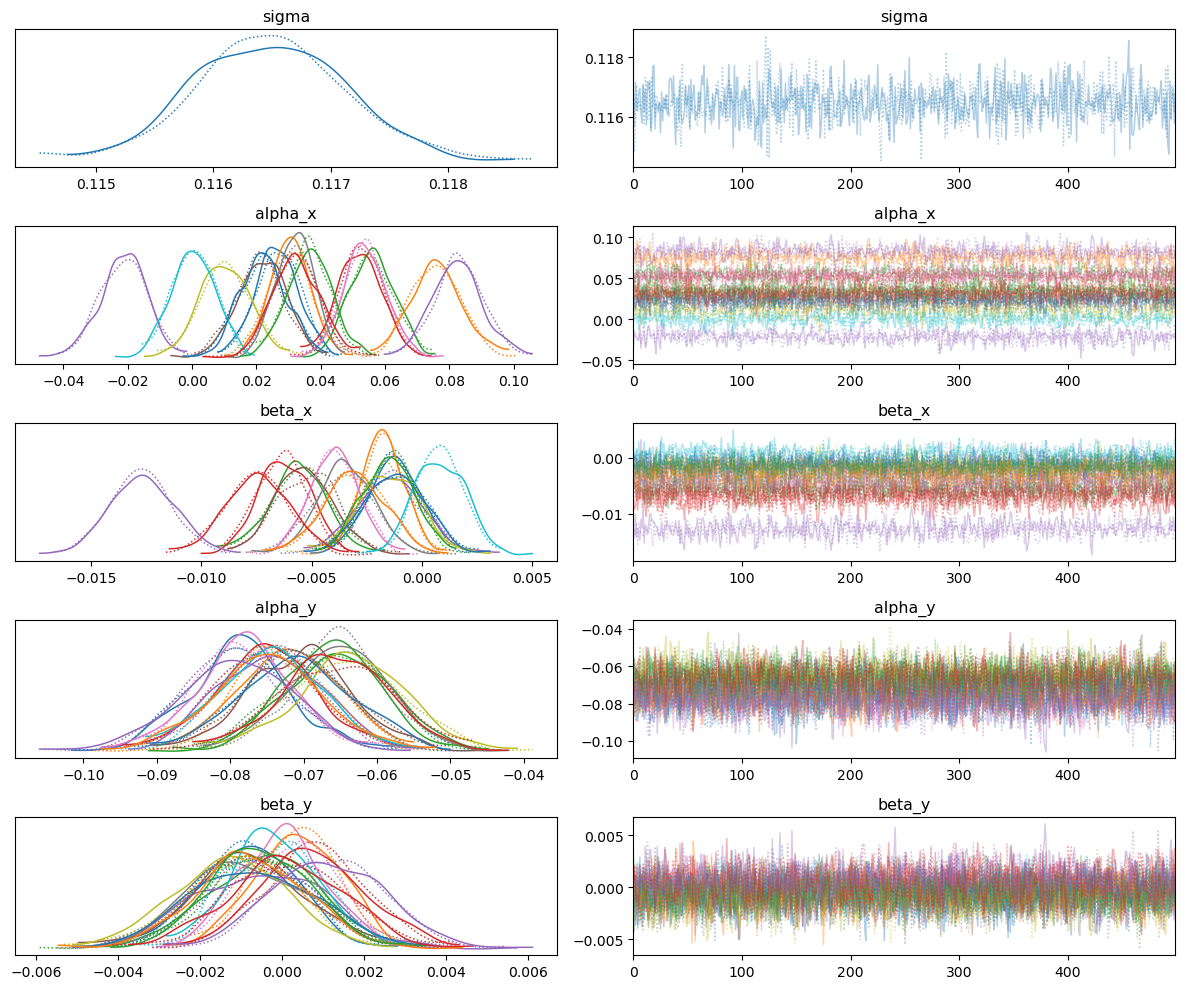

In [64]:
az.plot_trace(gaze_fit, var_names=['sigma', 'alpha_x', 'beta_x', 'alpha_y', 'beta_y'])
plt.tight_layout()

Finally, grab the predicted gaze data and compare it to actual gaze data.

In [81]:
results = gaze_fit.to_frame()
start = results.shape[1] - train_set.shape[0] * 2
results = results.iloc[:, start:]

In [82]:
results.shape

(1000, 19170)

<Axes: xlabel='Gaze.x.', ylabel='Count'>

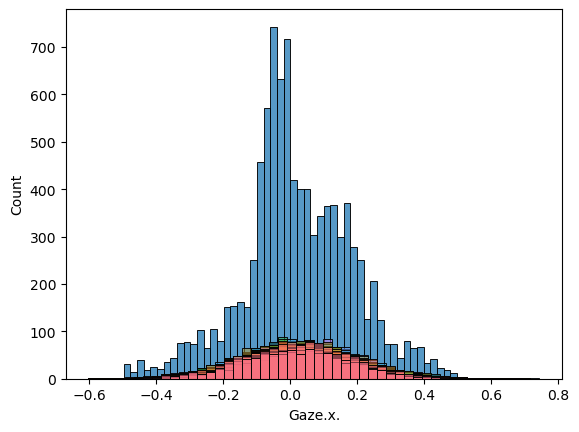

In [83]:
sns.histplot(train_set['Gaze.x.'], bins=50, legend=False)
sns.histplot(results.iloc[:,100:200], bins=50, legend=False)

<Axes: xlabel='Gaze.y.', ylabel='Count'>

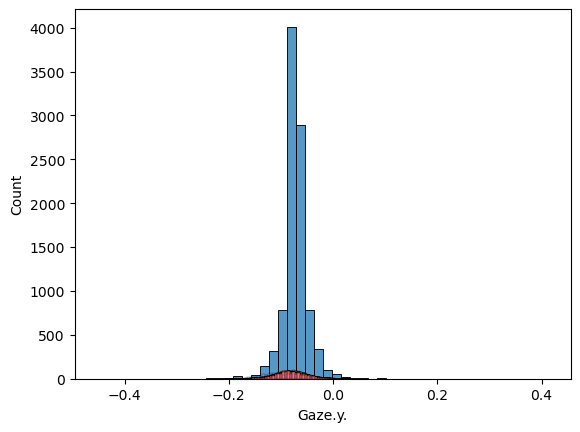

In [84]:
sns.histplot(train_set['Gaze.y.'], bins=50, legend=False)
sns.histplot(results.iloc[:,10000:10100], bins=50, legend=False)

<Axes: xlabel='Gaze.x.', ylabel='Gaze.y.'>

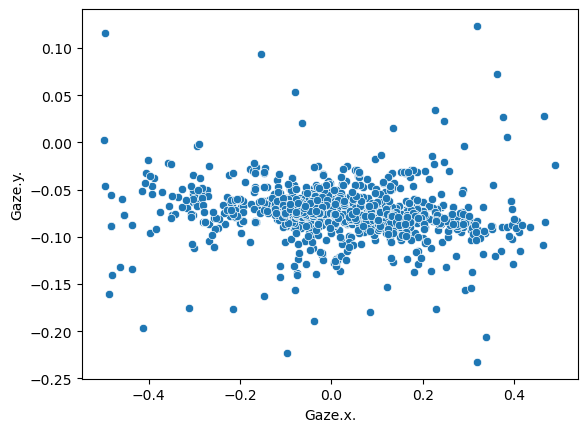

In [69]:
sns.scatterplot(x=train_set['Gaze.x.'], y=train_set['Gaze.y.'])

<Axes: >

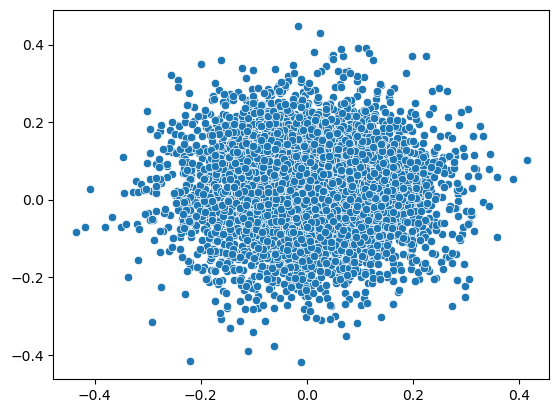

In [68]:
sns.scatterplot(x=results.iloc[1:100,700:750].values.flatten(), y=results.iloc[1:100,200:250].values.flatten())